In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy.stats import chi2

#general discussion- differences between tables, focus on minor accidents or fatal, matching road sections or creating new ones
#best way to analyze each variable

In [2]:
#importing data
file_path = 'involved_markers_hebrew.csv'
involved_markers_hebrew = pd.read_csv(file_path)
data = involved_markers_hebrew

In [ ]:
#data functions
def filtered_data(data, column):
    data_filtered = data.copy()
    data_filtered.sort_values(column)
    data_filtered.drop_duplicates(subset = column, keep = 'first', inplace = True)
    return data_filtered
    
def road_section(section_no):
    road_section = (data['road_segment_id']) == int(section_no)
    data_section = data[road_section]
    return data_section
def road_type(data,type_no):
    type_no = (data['road_type']) == int(type_no)
    data_road = data[type_no]
    return data_road
def road_street(street_no):
    road_street = (data['street1']) == int(street_no)
    data_street = data[road_street]
    return data_street

def data_years(data,start_year, end_year):
    data_years = (data['accident_year'] >= int(start_year)) & (data['accident_year'] <= int(end_year))
    return data[data_years]

def data_fatal(data):
    data_fatal = data[data['accident_severity'] == 1]
    return data_fatal

def fatal_road_section(section_no):
    road_section = (data_fatal['road_segment_id']) == int(section_no)
    data_fatal_section = data_fatal[road_section]
    return data_fatal_section

In [4]:
#creating unique data for markers analysis (reduces from 1897266 to 771638 [duplicates = 1125628])
data_filtered = filtered_data(data, 'provider_and_id')

#creating categorical columns

In [5]:
#return columns to binary - data['accident_type']=data['accident_type'].replace(to_replace=[2,3],value=0)
data['accident_type_1'] = data['accident_type'].replace(to_replace=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],value=0)

In [6]:
#return columns to binary - data['is_head-on'] = np.where(data['accident_type']==5,1,0) # type 5 is headon haziti
data['is_head-on'] = data['accident_type'].replace(to_replace = {1:0,2:0,3:0,4:0,5:1,6:0,7:0,8:0,9:0,
                                                           10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,
                                                           18:0,19:0,20:0}) 

In [7]:
#return columns to binary - data['is_weekend'] = np.where(data['day_in_week']>5,1,0) #Fri and Sat are weekends
#SUG_YOM‭
data['is_weekend'] = data['day_in_week'].replace(to_replace ={1:0,2:0,3:0,4:0,5:0,6:1,7:1})

#not binary - define as categorical
data['day_in_week'] = data['day_in_week'].astype('category')

In [8]:
#return columns to binary - data['is_daytime'] = data['day_night'].replace(5,0)#convert night (5) to 0
data['is_daytime'] = data['day_night'].replace(to_replace =[5], value = 0)

In [9]:
#return columns to binary - data['is_hard'] = data['accident_severity'].replace(3,0).replace([1,2],1) # hard accidents will get 1
data['is_hard'] = data['accident_severity'].replace({2:1,3:0})

In [10]:
#return columns to binary - data['is_jew'] = data['population_type'].replace([2,3,4,''],0)#convert non jews to 0
data['is_jew'] = data['population_type'].replace(to_replace = [2,3,4,''], value = 0)

In [11]:
#create different data frames by road section and road type
#road_segment_name: כניסה למצפה שלם - צומת שדי תרומות
data_900810 = road_section(900810)

data_4 = road_type(data, 4)
road_section_drop = data_4.road_segment_id != (900810)
data_4 = data_4[road_section_drop]

In [12]:
#create different data frames by road street and road type
#street1_hebrew: דרך בגין - ירושלים
data_1105 = road_street(1105)

data_2 = road_type(data, 2)
road_section_drop = data_2.street1 != (1105)
data_2 = data_2[road_section_drop]

In [13]:
#create different data frames by road section and road type
#road_segment_name: מחלף לקייה - צומת ערד
data_310020 = road_section(310020)

#data_4 = road_type(data, 4)
#road_section_drop = data_4.road_segment_id != (310020)
#data_4 = data_4[road_section_drop]


In [26]:
'''
function to check for every category if there are less accidents over the years
*please notice this isn't a statistic test, there's still a possibility the difference is big enough for reporting 
input: data and column name(str)
returns dataframe of Boolean, True means the number of accidents declined over the years in that category 
''' 
def year_diff(data, column):
    #creating data for each period
    data_08_10 = data_years(data, 2008, 2010)
    data_11_13 = data_years(data, 2011, 2013)
    data_14_16 = data_years(data, 2014, 2016)
    data_17_19 = data_years(data, 2017, 2019)
    #caculating the differences between 4 periods (weights added)
    return (((data_11_13.groupby(column).size()- data_08_10.groupby(column).size()) /
             ((data_11_13.groupby(column).size()+ data_08_10.groupby(column).size())/2))*0.15).round(2) + (((data_14_16.groupby(column).size()- data_11_13.groupby(column).size()) /
     ((data_14_16.groupby(column).size()+ data_11_13.groupby(column).size())/2))*0.25).round(2) +(((data_17_19.groupby(column).size()- data_14_16.groupby(column).size()) /
     ((data_17_19.groupby(column).size()+ data_14_16.groupby(column).size())/2))*0.6).round(2) <=  - 0.25

In [27]:
year_diff(data_310020, 'accident_severity') 

accident_severity
1     True
2    False
3     True
dtype: bool

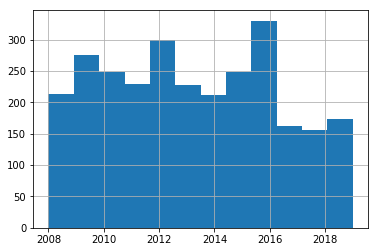

In [178]:
#presenting histogram for examining the difference between years
data_310020['accident_year'].hist(bins = 12, range =(2008, 2019))

#build function that finds the resource of the significance. find the differencess between the precents of observed and expected

In [66]:
'''
function to implement chi square 
input: data X 2(df) and column name(str)
if significant
returns dataframe of both
'''
def chi_test(data1, data2, column):
    #df for data1
    df1 = data1.groupby(column).size()
    df = pd.DataFrame(df1)
    df_idx = df.reset_index(inplace = False)
    df.columns =['column1']
    #df for data2
    df2 = data2.groupby(column).size()
    table = pd.DataFrame(df2)
    df_idx = table.reset_index(inplace = False)
    #combining both df
    df.insert(1,'column2',table)
    df = df.fillna(value = 0)

    #finding critical value
    from scipy.stats import chi2
    significance = 0.01
    p = 1 - significance
    dof = stats.chi2_contingency(df)[2]
    critical_value = chi2.ppf(p, dof)
    #comparing chi and significance values 
    if (int(stats.chi2_contingency(df, correction=True, lambda_="pearson")[1].round(2)) - significance) <= 0.05:
        if int(stats.chi2_contingency(df, correction=True, lambda_="pearson")[0].round(2)) - critical_value >= 0.1:
            return df
        else:
            return None   

In [15]:
'''
function to find chi square source of significance
input:df from chi_test function
if df is not None
returns table of diff between obs and exp precents, and index of the biggest difference
'''
def chi_sig(df):
    if df is not None:
        obs = df.copy()
        obs.reset_index(inplace = True)
        #creating sums
        sum_column1 = sum(obs['column1'])
        sum_column2 = sum(obs['column2'])
        #creating precents for obs
        obs['column1_per'] = obs['column1'].apply(lambda x: pd.Series((x/sum_column1*100), index = ['column1_per']))
        obs['column2_per'] = obs['column2'].apply(lambda x: pd.Series((x/sum_column2*100), index = ['column2_per']))
        #creating precents for exp
        exp = pd.DataFrame(stats.chi2_contingency(df, correction=True, lambda_="pearson")[3][:,0:2].round(2))
        exp['column1_per'] = exp[0].apply(lambda x: pd.Series((x/sum_column1*100), index = ['column1_per']))
        exp['column2_per'] = exp[1].apply(lambda x: pd.Series((x/sum_column2*100), index = ['column1_per']))

        return(obs.iloc[:, 3:5] - exp.iloc[:, 2:4]) , abs(obs.iloc[:, 3:5] - exp.iloc[:, 2:4]).idxmax()
    else:
        return None

In [16]:
df = chi_test(data_4, data_900810, 'accident_severity')
chi_sig(df)

(   column1_per  column2_per
 0    -0.040436     6.440897
 1    -0.056315     8.970233
 2     0.096751   -15.411130, column1_per    2
 column2_per    2
 dtype: int64)

#build function for fisher and t test

In [30]:
'''
function to implement fisher test 
input: data X 2(df) and column name (str)
if significant
returns dataframe of both and significance
'''
def fisher_test(data1, data2, column):
    #df for data1
    df1 = data1.groupby(column).size()
    df = pd.DataFrame(df1)
    df_idx = df.reset_index(inplace = False)
    df.columns =['column1']
    #df for data2
    df2 = data2.groupby(column).size()
    table = pd.DataFrame(df2)
    df_idx = table.reset_index(inplace = False)
    #combining both df
    df.insert(1,'column2',table)

    #comparing significance values
    significance = 0.01
    if (int(stats.fisher_exact(df, alternative='greater')[1].round(2)) - significance) <= 0.01:
            return df, stats.fisher_exact(df, alternative='greater')[1].round(2)
    else:
            return None

In [28]:
'''
function to present differences of precents
input:df from fisher_test function
if df is not None
returns table of percents for both columns
'''
def fisher_sig(df):
    if df is not None:
        obs = df.copy()
        obs.reset_index(inplace = True)
        #creating sums
        sum_column1 = sum(obs['column1'])
        sum_column2 = sum(obs['column2'])
        #creating precents for obs
        obs['column1_per'] = obs['column1'].apply(lambda x: pd.Series((x/sum_column1*100), index = ['column1_per']))
        obs['column2_per'] = obs['column2'].apply(lambda x: pd.Series((x/sum_column2*100), index = ['column2_per']))

        return obs.iloc[:,3:5]
    else:
        return None

In [23]:
df, sig = fisher_test(data_4, data_900810, 'is_head-on')
df, sig, fisher_sig(df)

(            column1  column2
 is_head-on                  
 0            354179     1921
 1             15047      397, 0.0,    column1_per  column2_per
 0    95.924718    82.873167
 1     4.075282    17.126833)

In [24]:
'''
function for recognizing the distribution type
input: data X 2(df), column name(str)
returns distribution type(str)
'''
def dist_type(data1, data2, column):
    mean1 = data1.groupby([column]).size().mean()
    median1 = data1.groupby([column]).size().median()
    mean2 = data2.groupby([column]).size().mean()
    median2 = data2.groupby([column]).size().median()
    if abs((mean1 - median1)/ ((mean1 + median1)/2)) < 0.1 :
        if abs((mean2 - median2)/ ((mean2 + median2)/2)) < 0.1:
            return 'mean'
        else:
            return 'median'

In [25]:
dist_type(data_4, data_900810, 'accident_year')

'mean'

In [67]:
'''
function to implement T test 
input: data X 2(df), column name(str) and data center, for normal distribution - 'mean' 
unnormal distributions and categorical - 'median'
preformes levene test for equal variance
if significant
returns dataframe of both and significance
'''
def t_test(data1, data2, column, center = 'median'):
    levene = stats.levene(data1[column] ,data2[column], center = center)
    if levene[1] < 0.01:
        equal_var = False
    else:
        equal_var = True
    return stats.ttest_ind(data1[column] ,data2[column], equal_var = equal_var)[1].round(2)

In [27]:
t_test(data_4, data_900810, 'day_in_week')

0.17

In [68]:
t_test(data_2, data_1105, 'accident_year', 'mean')

0.0